In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from numba import njit
from astropy.nddata import Cutout2D
from scipy.ndimage import uniform_filter
from scipy.ndimage import map_coordinates
from scipy.signal import fftconvolve
from scipy.fft import rfft2, irfft2, ifftshift
import numpy as np
import glob
import gc
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
from src.class_implementation import GAAP_object
warnings.filterwarnings("ignore")

In [363]:
from numba import njit
from astropy.nddata import Cutout2D
from scipy.ndimage import uniform_filter
from scipy.ndimage import map_coordinates
from scipy.signal import fftconvolve
from scipy.fft import rfft2, irfft2, ifftshift
import numpy as np
import glob
import gc
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")


def find_noise_square(image, box_size=50):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    half = box_size // 2
    local_std[:half, :] = np.inf
    local_std[-half:, :] = np.inf
    local_std[:, :half] = np.inf
    local_std[:, -half:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return image[y0:y1, x0:x1]


def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)


def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


# # @njit
# def weighted_variance_lag(s, C_local, max_lag):
#     H, W = s.shape
#     V = 0.0
#     for dy in range(-max_lag, max_lag + 1):
#         for dx in range(-max_lag, max_lag + 1):
#             y0 = max(0, -dy)
#             y1 = min(H, H - dy)
#             x0 = max(0, -dx)
#             x1 = min(W, W - dx)
#             s1 = s[y0:y1, x0:x1]
#             s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
#             V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
#     return V

# @njit(fastmath=True)


def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)


def gaussian_weight(height, width, xc=0, yc=0, a=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, a)
    return gy[:, None] * gx[None, :]


def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }


def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]


def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(
        flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()


def padded_cutout_with_center(image, cx, cy, size):
    """
    Extract a fixed-size cutout centered on (cy, cx).
    Pads with zeros when the cutout extends beyond the image.

    Returns
    -------
    cutout : (size, size) array
    (cy_c, cx_c) : subpixel center in cutout coordinates
    """

    h, w = image.shape
    half = size // 2

    # Integer anchor
    iy = int(np.floor(cy))
    ix = int(np.floor(cx))

    # Desired bounds in image coordinates
    y0 = iy - half
    x0 = ix - half
    y1 = y0 + size
    x1 = x0 + size

    # Overlap with image
    iy0 = max(0, y0)
    ix0 = max(0, x0)
    iy1 = min(h, y1)
    ix1 = min(w, x1)

    # Corresponding region in cutout coordinates
    cy0 = iy0 - y0
    cx0 = ix0 - x0
    cy1 = cy0 + (iy1 - iy0)
    cx1 = cx0 + (ix1 - ix0)

    # Allocate cutout
    cutout = np.zeros((size, size), dtype=image.dtype)

    # Insert image data
    cutout[cy0:cy1, cx0:cx1] = image[iy0:iy1, ix0:ix1]

    # Center in cutout coordinates
    cy_c = cy - y0
    cx_c = cx - x0

    return cutout, (cx_c, cy_c)


def create_psf(
    image: np.ndarray,
    catalog: Table,
    psf_size: int,
    window_size: float = 0.1,
    lower_percentile: float = 98.0,
    upper_percentile: float = 99.9,
    increase_window_factor: float = 2,
    minimum_log_flux=8,
    plot_chimney: bool = False,
    plot_psf: bool = False,
) -> np.ndarray:
    """
    Create a point spread function (PSF) using saturated stars identified in a catalog.

    Args:
        image (np.ndarray): 2D image array.
        catalog (Table): Source catalog containing star positions (must include at least x, y).
        psf_size (int): Final PSF cutout size in pixels.
        window_size (float, optional): Initial window size factor used around saturated stars. Defaults to 0.1.
        lower_percentile (float, optional): Lower percentile for saturation thresholding. Defaults to 98.0.
        upper_percentile (float, optional): Upper percentile for saturation thresholding. Defaults to 99.9.
        increase_window_factor (float, optional): Factor by which the window may grow if needed. Defaults to 2.
        plot_chimney (bool, optional): If True, plot each star cutout (chimney plot). Defaults to False.
        plot_psf (bool, optional): If True, plot the final PSF image. Defaults to False.

    Returns:
        np.ndarray: The computed PSF image with shape (psf_size, psf_size).
    """
    # Opening the flux and flux radius
    log_flux_radius = np.log(catalog["FLUX_RADIUS"])
    log_flux = np.log(catalog["FLUX_AUTO"])
    mask = np.isfinite(log_flux_radius) & np.isfinite(log_flux)

    # Calculate the flux radius that has the highest total flux within a window size
    maximum_flux = -np.inf
    center_maximum = -np.inf
    for window_center in np.linspace(min(log_flux_radius[mask]), max(log_flux_radius[mask]), 100):
        # Select region around window center
        new_mask = (
            np.isfinite(log_flux_radius)
            & np.isfinite(log_flux)
            & (log_flux_radius > window_center - window_size)
            & (log_flux_radius < window_center + window_size)
            & (log_flux > minimum_log_flux)
        )

        # Check if the total flux in region is maximum
        if np.sum(log_flux[new_mask]) > maximum_flux:
            maximum_flux = np.sum(log_flux[new_mask])
            center_maximum = window_center

    # Select all the sources in the found chimney
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
    )

    # Make a selection of the sources in the chinmey
    percentiles = np.percentile(log_flux[selection_mask], [
                                lower_percentile, upper_percentile])
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
        & (log_flux > percentiles[0])
        & (log_flux < percentiles[1])
    )

    # Make cutouts of the selected sources
    positions = catalog[selection_mask][["X_IMAGE", "Y_IMAGE"]]
    n_cutouts = len(positions)
    cutouts = np.empty((n_cutouts, psf_size, psf_size), dtype=image.dtype)
    for i, (x, y) in enumerate(positions):
        cutout = Cutout2D(image, (x, y), psf_size,
                          mode="partial", fill_value=np.nan)
        cutouts[i] = cutout.data

    # Average the cutouts to create the PSF
    psf = np.nanmean(cutouts, axis=0)

    # Plot the flux, flux radius plot with the selected sources highlighted
    if plot_chimney and plot_psf:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # Left plot: chimney
        axes[0].scatter(log_flux_radius[mask], log_flux[mask],
                        color="b", s=1, alpha=0.5, label="Sources")
        axes[0].scatter(
            log_flux_radius[selection_mask],
            log_flux[selection_mask],
            s=1,
            alpha=0.5,
            color="r",
            label="Selected Sources for PSF",
        )
        axes[0].set_xlabel("log(flux radius)")
        axes[0].set_ylabel("log flux")
        axes[0].legend()
        axes[0].set_title("Chimney Plot")

        # Right plot: PSF
        im = axes[1].imshow(np.log(psf), cmap="gray")
        axes[1].set_title("PSF")
        fig.colorbar(im, ax=axes[1], fraction=0.046,
                     pad=0.04)  # optional colorbar

        plt.tight_layout()
        plt.show()

    else:
        # Individual plots as before
        if plot_chimney:
            plt.scatter(log_flux_radius[mask], log_flux[mask],
                        color="b", s=1, alpha=0.5, label="Sources")
            plt.scatter(
                log_flux_radius[selection_mask],
                log_flux[selection_mask],
                s=1,
                alpha=0.5,
                color="r",
                label="Selected Sources for PSF",
            )
            plt.xlabel("log(flux radius)")
            plt.ylabel("log flux")
            plt.legend()
            plt.show()

        if plot_psf:
            plt.imshow(np.log(psf), cmap="gray")
            plt.show()

    # Normalize the PSF
    psf /= np.sum(psf)

    return psf


def process_filter_2(args):
    (
        filter,
        location,
        field,
        ra_reference,
        dec_reference,
        size,
        maxlag,
        aperture_size_array,
        psf,
        noise_cutout,
        hdu_index
    ) = args

    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[hdu_index]
        image = hdu.data
        wcs = WCS(hdu.header)
        nx = hdu.header["NAXIS1"]
        ny = hdu.header["NAXIS2"]
        if hdu_index == 0:
            zeropoint = hdu.header["MAGZERO"]
            conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
        else:
            conversion_factor = 1

    x_c, y_c = wcs.wcs_world2pix(
        ra_reference, dec_reference, 0, ra_dec_order=True
    )

    mask = (
        (x_c >= 0) & (x_c < nx) &
        (y_c >= 0) & (y_c < ny) &
        (~np.isnan(aperture_size_array))
    )

    cache = prepare_wiener_psf(psf, [size, size])
    local_covariance = covariance_fft2d(noise_cutout, maxlag)

    n = len(x_c)
    flux_out = np.full(n, np.nan, dtype=np.float32)
    sigma_out = np.full(n, np.nan, dtype=np.float32)

    for i, (x_center, y_center, valid) in enumerate(zip(x_c, y_c, mask)):
        if not valid:
            continue

        cutout, new_center = padded_cutout_with_center(
            image, x_center, y_center, size
        )

        cutout = cutout.astype(np.float32, copy=False)
        cutout *= conversion_factor

        weight = gaussian_weight(
            size, size, size / 2, size / 2, aperture_size_array[i]
        )

        weight_rescale = wiener_deconvolution_fast(weight, cache)

        flux_map = fftconvolve(cutout, weight_rescale[::-1, ::-1], mode='same')

        flux = bilinear_sample(flux_map, new_center[0], new_center[1])

        variance = weighted_variance_lag(
            weight_rescale, local_covariance, maxlag)

        flux_out[i] = flux
        sigma_out[i] = np.sqrt(variance)

        if i % 2500 == 0:
            gc.collect()

    return filter, flux_out, sigma_out


@njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# def weighted_variance_lag(s, C_local, max_lag):
#     # Convolution with flipped version of s
#     conv = fftconvolve(s, s[::-1, ::-1], mode="full")

#     cy, cx = np.array(conv.shape) // 2
#     conv_local = conv[
#         cy - max_lag: cy + max_lag + 1,
#         cx - max_lag: cx + max_lag + 1,
#     ]

#     return np.sum(conv_local * C_local)

# Bilinear interpolation of weight
def bilinear_shift(W, dx, dy):
    W_shifted = (1-dx)*(1-dy)*W[:-1, :-1] + dx*(1-dy)*W[:-1, 1:] \
                + (1-dx)*dy*W[1:, :-1] + dx*dy*W[1:, 1:]
    return W_shifted


@njit
def bilinear_sample(img, x, y):
    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    dx = x - x0
    dy = y - y0

    return (
        img[y0, x0] * (1 - dx) * (1 - dy) +
        img[y0, x0 + 1] * dx * (1 - dy) +
        img[y0 + 1, x0] * (1 - dx) * dy +
        img[y0 + 1, x0 + 1] * dx * dy
    )

class GAAP_object:
    def __init__(self, image, centers, pixel_scale=1, psf: np.ndarray=None, sigmas=None, rms=None, image_conversion_factor=1, rms_conversion_factor=1):
        self.image = image
        self.ny, self.nx = image.shape
        self.centers = centers
        self.pixel_scale = pixel_scale
        self.psf = psf
        self.sigmas = sigmas / pixel_scale
        self.rms = rms
        self.image_conversion_factor = image_conversion_factor
        self.rms_conversion_factor = rms_conversion_factor
        self.noise_square = None
        self.flux = None
        self.variance = None

    def find_noise_square(self, image, box_size=50):
        """
        Automatically find a square region with low signal (noise-dominated).
        image: 2D array
        box_size: side of the square region (pixels)
        margin: exclude edges
        threshold: how many sigma above the median to consider as "source"
        returns: (y0, x0, y1, x1) slice indices of best noise square
        """

        # smooth absolute value to find low-variance zones
        local_mean = uniform_filter(image, size=box_size)
        local_var = uniform_filter(image**2, size=box_size) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))

        # exclude borders
        half = box_size // 2
        local_std[:half, :] = np.inf
        local_std[-half:, :] = np.inf
        local_std[:, :half] = np.inf
        local_std[:, -half:] = np.inf

        # pick minimum std region (least structured)
        cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

        # ensure square fits inside image
        half = box_size // 2
        y0 = max(0, cy - half)
        x0 = max(0, cx - half)
        y1 = min(self.ny, y0 + box_size)
        x1 = min(self.nx, x0 + box_size)

        self.noise_square = image[y0:y1, x0:x1]

    def create_poisson_image(self):
        x = self.image[self.image < 0]
        background_variance = np.sum(x * x) / len(x) * self.image_conversion_factor ** 2
        self.poisson_image = np.clip((self.rms * self.rms_conversion_factor)** 2 - background_variance, 0, None)

    def create_weights(self, sigmas, size):
        y0 = (size - 1) / 2
        x0 = (size - 1) / 2

        y, x = np.mgrid[:size, :size]
        r2 = (x - x0)**2 + (y - y0)**2

        return np.exp(
            -r2[None, :, :] / (2 * sigmas[:, None, None]**2)
        )

    def prepare_wiener_psf(self, image_shape=[100, 100], K=1e-16, dtype=np.float64):
        """
        Precompute PSF FFT terms for Wiener deconvolution.
        """

        psf = self.psf[::-1, ::-1].astype(dtype, copy=False)

        pad_shape = (
            image_shape[0] + psf.shape[0] - 1,
            image_shape[1] + psf.shape[1] - 1,
        )

        psf_padded = np.zeros(pad_shape, dtype=dtype)
        y0 = pad_shape[0] // 2 - psf.shape[0] // 2
        x0 = pad_shape[1] // 2 - psf.shape[1] // 2
        psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

        H = rfft2(ifftshift(psf_padded))
        H_conj = np.conj(H)
        denom = (H * H_conj) + K

        self.psf_cache = {
            "PSF_prefactor": H_conj/denom,
            "pad_shape": pad_shape
        }

    def deconvolve_weights(self, weights, size, dtype=np.float32):
        pad_shape = self.psf_cache["pad_shape"]
        if not hasattr(self, "_fft_buffers"):
            test = rfft2(weights, pad_shape)
            self._fft_buffer = np.empty(test.shape, dtype=np.complex128)
        weights = weights.astype(dtype, copy=False)
        self._fft_buffer = rfft2(weights, pad_shape)
        self._fft_buffer *= self.psf_cache["PSF_prefactor"]
        result = irfft2(self._fft_buffer, pad_shape)
        return result[:size, :size,]

    def set_noise_covariance(self, maxlag, noise_image=None):
        if noise_image == None:
            noise_image = self.noise_square
        self.noise_covariance = self.covariance_fft2d(noise_image * self.image_conversion_factor, maxlag)

    def estimate_variance(self, weight, maxlag):
        return weighted_variance_lag(weight, self.noise_covariance, maxlag)

    def covariance_fft2d(self, image, maxlag):
        """
        Compute 2D covariance by FFT of background-subtracted residual.
        - image: 2D array (float)
        - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
        Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
        """
        img = image.astype(float)
        h, w = img.shape
        img -= np.mean(img)

        ac = fftconvolve(img, img[::-1, ::-1], mode="same")

        ac_norm = ac / (h * w)

        cy, cx = h//2, w//2
        window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
        return window

    def calculate_gaap_flux(self, size, maxlag):
        x_c, y_c = self.centers
        n_sources = self.centers.shape[1]

        if self.flux is None or len(self.flux) != n_sources:
            self.flux = np.full(n_sources, np.nan, dtype=np.float64)
            self.variance = np.full(n_sources, np.nan, dtype=np.float64)

        # valid sources mask
        mask = (x_c >= 0) & (x_c < self.nx) & (y_c >= 0) & (y_c < self.ny)
        valid_idx = np.where(mask)[0]
        sorted_idx = valid_idx[np.argsort(self.sigmas[valid_idx])]

        last_aperture = None
        weight_rescale = None
        background_variance = None
        for j,i in enumerate(sorted_idx):
            xc, yc = x_c[i], y_c[i]
            aperture = self.sigmas[i]

            # Only recompute Wiener-deconvolved weight if aperture size changed
            if aperture != last_aperture:
                weight = gaussian_weight(size, size, size/2, size/2, aperture)
                weight_rescale = self.deconvolve_weights(weight, size)
                weight_rescale2 = weight_rescale ** 2
                last_aperture = aperture
                background_variance = weighted_variance_lag(weight_rescale, self.noise_covariance, maxlag)

            # Extract cutout
            cutout, (cx_cut, cy_cut) = padded_cutout_with_center(self.image, xc, yc, size)
            poisson_cutout, _ = padded_cutout_with_center(self.poisson_image, xc, yc, size)
            cutout *= self.image_conversion_factor

            # Subpixel offsets
            dx = cx_cut - np.floor(cx_cut)
            dy = cy_cut - np.floor(cy_cut)

            W_shifted = bilinear_shift(weight_rescale, dx, dy)
            W2_shifted = bilinear_shift(weight_rescale2, dx, dy)

            # Trim cutout to match shifted weight
            cutout_trim = cutout[:W_shifted.shape[0], :W_shifted.shape[1]]
            poisson_trim = poisson_cutout[:W2_shifted.shape[0], :W2_shifted.shape[1]]

            # Weighted sums
            self.flux[i] = np.sum(W_shifted * cutout_trim)
            poisson_variance = np.sum(W2_shifted * poisson_trim)
            self.variance[i] = background_variance + poisson_variance

            if j % 2500 == 0:
                print(j)
                gc.collect()
        
        self.flux /= self.pixel_scale**2
        self.sigmas /= self.pixel_scale**2

In [67]:
# Set location of the data
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

# Set the field
field = '53.0_-28.0'

filter = 'u'
hdu_index = 1

In [68]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [69]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [26]:
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

In [71]:
filter = 'DES-G'

In [ ]:
files = glob.glob(f'{location}/{field}/{filter}_*.fits.gz')
print(files)
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    zeropoint = hdu.header["MAGZERO"]
    image_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
    image = hdu.data
files = glob.glob(f'{location}/{field}/EUC_MER_MOSAIC-{filter}-RMS_*.fits')
print(files)
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=False) as hdul:
    hdu = hdul[0]
    zeropoint = hdu.header["MAGZERO"]
    rms_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
    rms = hdu.data

['/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_MOSAIC-DES-G-RMS_TILE102044185-CF5BB0_20241021T002643.723780Z_00.00.fits']


In [167]:
files = glob.glob(f'{location}/{field}/{filter}_*.fits.gz')
print(files)
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    zeropoint = hdu.header["MAGZERO"]
    image_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
    image = hdu.data

['/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/DES-G_TILE102044185.fits.gz']


In [169]:
gc.collect()

17

In [170]:
files = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-{filter}_*.fits')
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=True) as hdul:
    psf = hdul[1].data

In [ ]:
for i in range(1, psf.shape[0]//2):
    if psf.shape[0] % i == 0:
        print(i)

1
3
7
21
43
49
129
147
301
903
2107


In [171]:
psf_size = 49
Ng = psf.shape[0] // psf_size   # 203

psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
psfs = psfs.transpose(0, 2, 1, 3)
central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
mean_psf = np.mean(central, axis=(0, 1))
mean_psf /= mean_psf.sum()

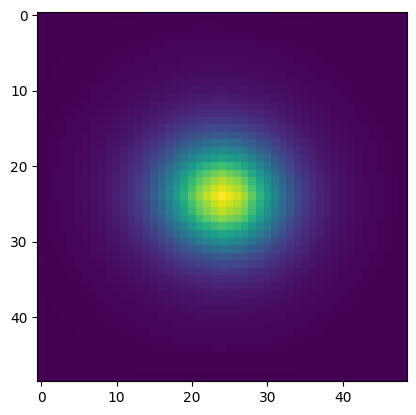

In [152]:
plt.imshow(mean_psf)

New Complete Code Single Filter

In [186]:
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
from scipy.optimize import curve_fit

In [175]:
files = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-VIS_*.fits')
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=True) as hdul:
    psf = hdul[1].data

In [176]:
for i in range(1, psf.shape[0]//2):
    if psf.shape[0] % i == 0:
        print(i)

1
2
3
4
6
7
9
12
14
18
21
27
28
36
42
54
63
81
84
108
126
162
189
243
252
324
378
486
567
756
972
1134
1701
2268


In [183]:
psf_size = 21
Ng = psf.shape[0] // psf_size   # 203

psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
psfs = psfs.transpose(0, 2, 1, 3)
central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
mean_psf = np.mean(central, axis=(0, 1))
mean_psf /= mean_psf.sum()

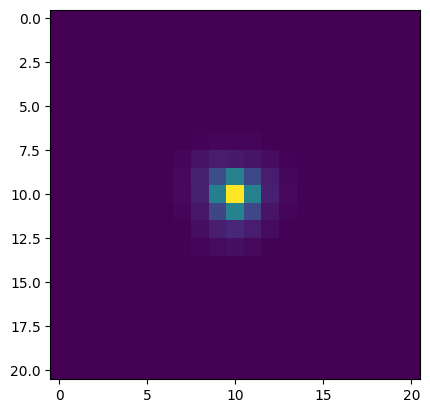

In [184]:
plt.imshow(mean_psf)

In [185]:
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_euclid = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_euclid)
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                19200                                                  NAXIS2  =                19200                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   5.298695150000E+01 / World coordinate on this axis                  CRPIX1  =                 9600 / Reference pixel on this axis                   CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       CD1_2   =   0.000000000000E+00 / Linear 

In [188]:
original_sizes = np.linspace(2, 30, 30)
size = 64
psf_cache = prepare_wiener_psf(mean_psf, [size, size], K=1e-16)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(size, size, size / 2, size / 2, original_size)
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

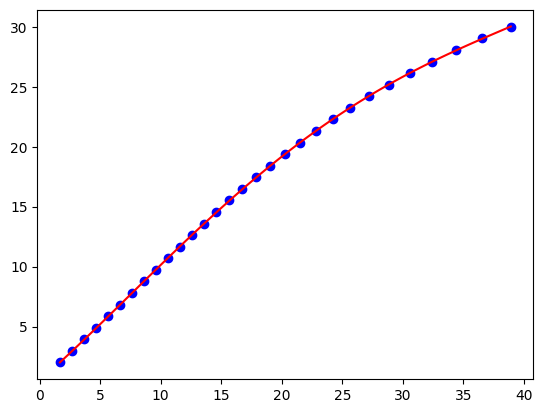

In [189]:
from numpy.polynomial import Polynomial
n = 4
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [190]:
amplitude_guess = np.mean(image[:3400, :3400])
sigma_guess = 2
initial_guess = [amplitude_guess, sigma_guess]

In [191]:
size = 64
aperture_size = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(zip(x_c, y_c)):
    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - size//2)
    x_max = min(nx, x0 + size//2 + 1)
    y_min = max(0, y0 - size//2)
    y_max = min(ny, y0 + size//2 + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    x_center_cutout = x_center - x_min
    y_center_cutout = y_center - y_min

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]
    # plt.imshow(cutout)
    # plt.scatter(x_center_cutout, y_center_cutout, c='r')
    # plt.show()
    # break
    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        aperture_size[i] = f(np.abs(popt[1])) * pixel_scale_euclid
        if i % 5000 == 0:
            print(i)
            # plt.imshow(cutout)
            # plt.plot([x_center_cutout, x_center_cutout+np.abs(popt[1])], [y_center_cutout, y_center_cutout+np.abs(popt[1])], c='r')
            # plt.show()
            gc.collect()
    except RuntimeError:
        print('error')
        aperture_size[i] = np.inf

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
error
50000
error
55000
60000
65000
70000
75000
80000
error
error
85000
error
error
error
90000
error
error
95000


In [ ]:
bins = np.linspace(.7, 1.1, 100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# prepare array
sigma_binned = np.full_like(aperture_size, np.nan, dtype=float)

# mask valid (non-NaN) entries
mask = ~np.isnan(aperture_size)

# digitize only valid entries
bin_idx = np.digitize(aperture_size[mask], bins) - 1
bin_idx = np.clip(bin_idx, 0, len(bin_centers) - 1)

# assign binned values
sigma_binned[mask] = bin_centers[bin_idx]
plt.hist(sigma_binned[~np.isnan(sigma_binned)], bins=bin_centers)
plt.xlabel('Binned Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Binned Fitted Gaussian Sigmas for Sources')
plt.yscale('log')
plt.show()

In [377]:
fluxes = {}

for filter in ['DES-G', 'DES-R', 'DES-I']:
    file = glob.glob(f'{location}/{field}/{filter}_*.fits.gz')[0]
    with fits.open(file, memmap=True) as hdul:
        hdu = hdul[0]
        zeropoint = hdu.header["MAGZERO"]
        image_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
        image = hdu.data
        wcs = WCS(hdu.header)

    centers = wcs.wcs_world2pix(
            ra_reference, dec_reference, 0, ra_dec_order=True
            )
    
    file = glob.glob(f'{location}/{field}/EUC_MER_MOSAIC-{filter}-RMS_*.fits')[0]
    with fits.open(file, memmap=False) as hdul:
        hdu = hdul[0]
        zeropoint = hdu.header["MAGZERO"]
        rms_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
        rms = hdu.data
    
    file = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-{filter}_*.fits')[0]
    with fits.open(file, memmap=True) as hdul:
        psf = hdul[1].data

    psf_size = 49
    Ng = psf.shape[0] // psf_size

    psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
    psfs = psfs.transpose(0, 2, 1, 3)
    central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
    mean_psf = np.mean(central, axis=(0, 1))
    mean_psf /= mean_psf.sum()

    size = 128
    lag = 8
    des_g = GAAP_object(image, np.asarray(centers), pixel_scale_euclid, psf=mean_psf, sigmas=sigma_binned, rms=rms, image_conversion_factor=image_conversion_factor, rms_conversion_factor=rms_conversion_factor)
    des_g.create_poisson_image()
    des_g.prepare_wiener_psf([size, size])
    des_g.find_noise_square(des_g.image[:3400, :3400], 80)
    des_g.set_noise_covariance(lag)
    des_g.calculate_gaap_flux(size, lag)

    fluxes[filter] = des_g.flux
    fluxes[f'{filter}_sigma'] = np.sqrt(des_g.variance)
    

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000


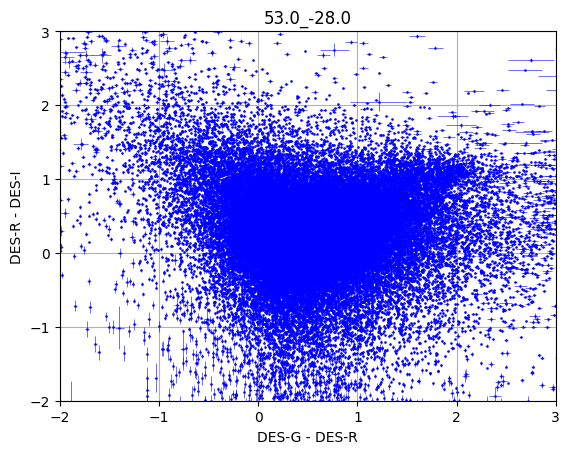

In [392]:
filter_1 = 'DES-G'   # e.g., master_table column name
filter_2 = 'DES-R'
filter_3 = 'DES-R'
filter_4 = 'DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
gaap_error = xerr**2 + yerr**2
mask = (cat['POINT_LIKE_PROB'] < 0.5 ) & (gaap_error < 1)
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1} - {filter_2}')
plt.ylabel(f'{filter_3} - {filter_4}')
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.grid(True)
plt.show()

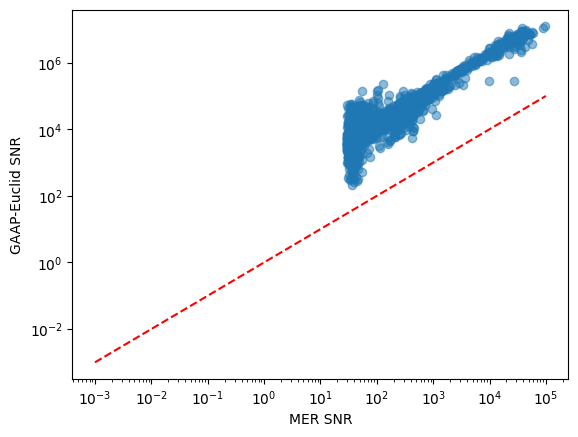

Percent of sources where GAAP-Euclid SNR > MER SNR: 1.0
Average SNR improvement factor (GAAP-Euclid / MER): 157.21953311050189


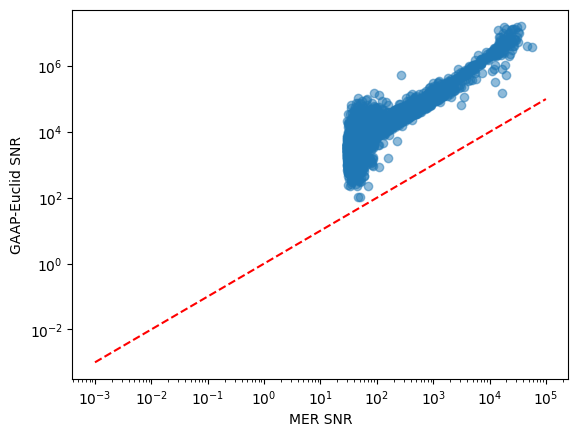

Percent of sources where GAAP-Euclid SNR > MER SNR: 1.0
Average SNR improvement factor (GAAP-Euclid / MER): 135.43032168862774


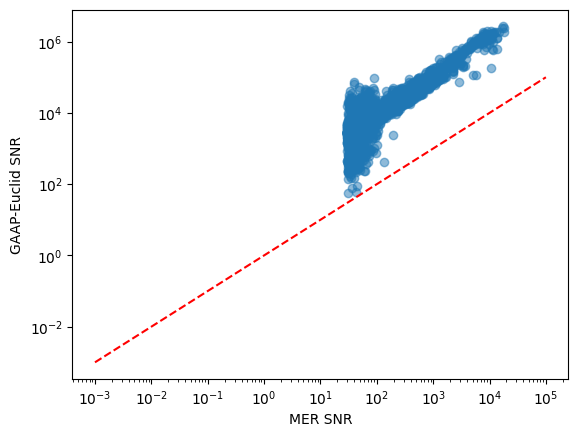

Percent of sources where GAAP-Euclid SNR > MER SNR: 1.0
Average SNR improvement factor (GAAP-Euclid / MER): 104.71462295955497


In [397]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'DES-{filter}']/fluxes[f'DES-{filter}_sigma']
    cutoff_snr = 30
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

In [208]:
filter = 'DES-G'

In [ ]:
file = glob.glob(f'{location}/{field}/{filter}_*.fits.gz')[0]
with fits.open(file, memmap=True) as hdul:
    hdu = hdul[0]
    zeropoint = hdu.header["MAGZERO"]
    image_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
    image = hdu.data
    wcs = WCS(hdu.header)

centers = wcs.wcs_world2pix(
        ra_reference, dec_reference, 0, ra_dec_order=True
        )

In [218]:
file = glob.glob(f'{location}/{field}/EUC_MER_MOSAIC-{filter}-RMS_*.fits')[0]
with fits.open(file, memmap=False) as hdul:
    hdu = hdul[0]
    zeropoint = hdu.header["MAGZERO"]
    rms_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
    rms = hdu.data

In [372]:
filter = 'DES-I'

In [373]:
file = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-{filter}_*.fits')[0]
with fits.open(file, memmap=True) as hdul:
    psf = hdul[1].data

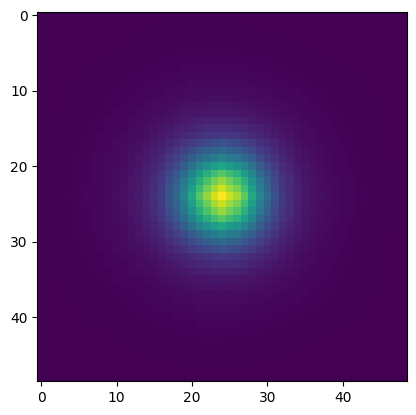

In [ ]:
psf_size = 49
Ng = psf.shape[0] // psf_size

psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
psfs = psfs.transpose(0, 2, 1, 3)
central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
mean_psf = np.mean(central, axis=(0, 1))
mean_psf /= mean_psf.sum()
plt.imshow(mean_psf)
plt.show()

In [228]:
print(mean_psf)

[[4.76873726e-06 7.12376166e-06 7.79879161e-06 ... 6.41023364e-06
  5.67866687e-06 8.16368528e-07]
 [6.40236800e-06 9.65431308e-06 1.06227946e-05 ... 8.74773829e-06
  7.71971210e-06 1.14067367e-06]
 [6.92624190e-06 1.04877353e-05 1.16093966e-05 ... 9.57652344e-06
  8.42673672e-06 1.23618180e-06]
 ...
 [5.72996905e-06 8.57585995e-06 9.41245343e-06 ... 8.91165079e-06
  7.86410875e-06 1.14015347e-06]
 [4.98769392e-06 7.41753025e-06 8.11233075e-06 ... 7.68639126e-06
  6.80608264e-06 9.71319271e-07]
 [3.49196556e-07 5.64943084e-07 6.15909821e-07 ... 5.81844039e-07
  5.11942898e-07 1.09556112e-07]]


In [364]:
size = 128
lag = 8
des_g = GAAP_object(image, np.asarray(centers), pixel_scale_euclid, psf=mean_psf, sigmas=sigma_binned, rms=rms, image_conversion_factor=image_conversion_factor, rms_conversion_factor=rms_conversion_factor)
des_g.create_poisson_image()
des_g.prepare_wiener_psf([size, size])
des_g.find_noise_square(des_g.image[:3400, :3400], 80)
des_g.set_noise_covariance(lag)

In [365]:
des_g.calculate_gaap_flux(size, lag)

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000


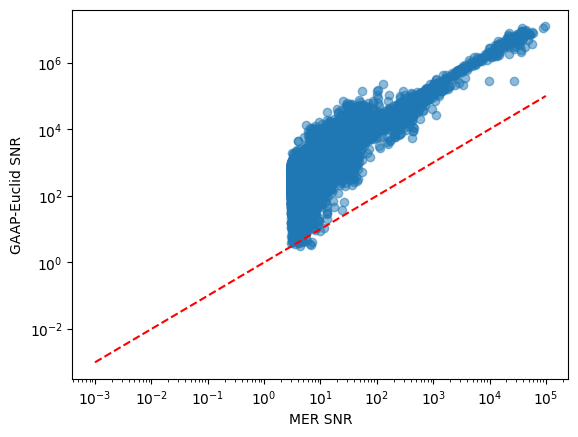

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9997567163660376
Average SNR improvement factor (GAAP-Euclid / MER): 122.01164591894516


In [367]:
snr_meer = cat[f'FLUX_{filter[-1]}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter[-1]}_EXT_DECAM_4FWHM_APER']
snr_gaap_euclid = des_g.flux / np.sqrt(des_g.variance)
cutoff_snr = 3
mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
plt.scatter(snr_meer[mask],
            snr_gaap_euclid[mask],
            alpha=0.5)
plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
plt.xlabel('MER SNR')
plt.ylabel('GAAP-Euclid SNR')
plt.loglog()
plt.show()
print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))